In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
ld = pd.read_csv("Load_data.csv")
ld.head()

,Load
0,1001
1,967
2,946
3,939
4,934


17544

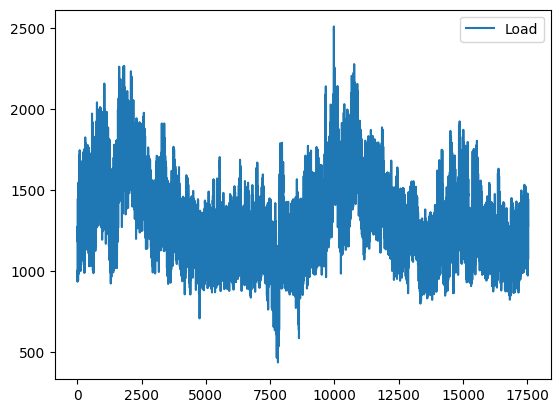

In [3]:
ld.plot()
ld.size

In [4]:
da = pd.date_range(start='11/1/2003', end='11/1/2005', periods=17545, closed='right')
r = np.array(da, dtype='datetime64[h]')
rr = pd.DataFrame(r, columns=['Time'])
rr.tail()


C:\Users\prede\AppData\Local\Temp\ipykernel_19268\1644015983.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  da = pd.date_range(start='11/1/2003', end='11/1/2005', periods=17545, closed='right')


,Time
17539,2005-10-31 20:00:00
17540,2005-10-31 21:00:00
17541,2005-10-31 22:00:00
17542,2005-10-31 23:00:00
17543,2005-11-01 00:00:00


In [5]:
ldd = pd.concat([rr, ld], axis=1)
ldd.Time = pd.to_datetime(ldd.Time)
print(ldd.info())
ldd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    17544 non-null  datetime64[ns]
 1   Load    17544 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 274.2 KB
None


,Time,Load
0,2003-11-01 01:00:00,1001
1,2003-11-01 02:00:00,967
2,2003-11-01 03:00:00,946
3,2003-11-01 04:00:00,939
4,2003-11-01 05:00:00,934


In [6]:
temp = pd.read_csv("temp.csv")
ldt = pd.concat([ldd, temp], axis=1)
ldt=ldt.set_index("Time")
ldt.head()
#The dataframe including the temperature data

,Load,Temp (C)
Time,,
2003-11-01 01:00:00,1001,16.8
2003-11-01 02:00:00,967,15.9
2003-11-01 03:00:00,946,15.9
2003-11-01 04:00:00,939,16.9
2003-11-01 05:00:00,934,16.3


In [7]:
#Generating the time in "Seconds" to generate a cos and sin map for periodicity relevance
ldt['Sec'] = ldt.index.map(pd.Timestamp.timestamp)
ldt

,Load,Temp (C),Sec
Time,,,
2003-11-01 01:00:00,1001,16.8,1.067648e+09
2003-11-01 02:00:00,967,15.9,1.067652e+09
2003-11-01 03:00:00,946,15.9,1.067656e+09
2003-11-01 04:00:00,939,16.9,1.067659e+09
2003-11-01 05:00:00,934,16.3,1.067663e+09
...,...,...,...
2005-10-31 20:00:00,1352,11.7,1.130789e+09
2005-10-31 21:00:00,1348,11.3,1.130792e+09
2005-10-31 22:00:00,1266,11.4,1.130796e+09


In [8]:
day = 86400 
#86400 is the number of seconds in a day
year = 31556952 
#31556952 is the number of seconds in an year

ldt['DSin'] = np.sin(ldt['Sec'] * (2*np.pi /day))
ldt['DCos'] = np.cos(ldt['Sec'] * (2*np.pi /day))
ldt['YSin'] = np.sin(ldt['Sec'] * (2*np.pi /year))
ldt['YCos'] = np.cos(ldt['Sec'] * (2*np.pi /year))
ldt.head()

,Load,Temp (C),Sec,DSin,DCos,YSin,YCos
Time,,,,,,,
2003-11-01 01:00:00,1001,16.8,1.067648e+09,0.258819,0.965926,-0.868846,0.495082
2003-11-01 02:00:00,967,15.9,1.067652e+09,0.500000,0.866025,-0.868491,0.495704
2003-11-01 03:00:00,946,15.9,1.067656e+09,0.707107,0.707107,-0.868136,0.496327
2003-11-01 04:00:00,939,16.9,1.067659e+09,0.866025,0.500000,-0.867780,0.496949
2003-11-01 05:00:00,934,16.3,1.067663e+09,0.965926,0.258819,-0.867423,0.497571


In [9]:
ldt =ldt.drop('Sec', axis=1)
ldt.head()
#Dropping the "Seconds" column

,Load,Temp (C),DSin,DCos,YSin,YCos
Time,,,,,,
2003-11-01 01:00:00,1001,16.8,0.258819,0.965926,-0.868846,0.495082
2003-11-01 02:00:00,967,15.9,0.500000,0.866025,-0.868491,0.495704
2003-11-01 03:00:00,946,15.9,0.707107,0.707107,-0.868136,0.496327
2003-11-01 04:00:00,939,16.9,0.866025,0.500000,-0.867780,0.496949
2003-11-01 05:00:00,934,16.3,0.965926,0.258819,-0.867423,0.497571


In [10]:
win = pd.concat([ldt['2003-12-01':'2004-02-29'],ldt['2004-12-01':'2005-02-28']])
frames = [ldt['2003-11-01':'2003-11-30'],ldt['2004-09-01':'2004-11-30'],ldt['2005-09-01':'2005-10-30']]
fal = pd.concat(frames)
spr = pd.concat([ldt['2004-03-01':'2004-05-31'],ldt['2005-03-01':'2005-05-31']])
sue = pd.concat([ldt['2004-06-01':'2004-08-30'],ldt['2005-06-01':'2005-06-30']])


win.to_csv('win.csv',index=False)
fal.to_csv('fal.csv',index=False)
spr.to_csv('spr.csv',index=False)
sue.to_csv('sum.csv',index=False)

In [11]:
#We generate the sliding window which is required for the LSTM model. The window size can be arbitrary and can depend on the dataset. Here, we use 5 hours of previous data to predict the next hour, Hence the size of the window will be 5. This can also be changed later for further tweaks to increase the accuracy of the model.
def dataframe_win(df, w_size=7):
    df_np = df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_np)-w_size):
        row =[r for r in df_np[i:i+w_size]]
        X.append(row)
        label = df_np[i+w_size][0]
        y.append(label)
    return np.array(X), np.array(y)


# Winter season dataset training and prediction

In [12]:
X, y = dataframe_win(win)
X.shape, y.shape

((4337, 7, 6), (4337,))

In [16]:
X_train, y_train = X[:'2004-02-29'], y[:'2004-02-29']
X_val, y_val = X['2004-12-01':'2005-01-31'], y['2004-12-01':'2005-01-31']
X_test, y_test = X['2005-02-01':'2005-02-28'], y['2005-02-01':'2005-02-28']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

TypeError: slice indices must be integers or None or have an __index__ method

In [15]:
load_train_mean = np.mean(X_train[:, :, 0])
load_train_std = np.std(X_train[:, :, 0])

temp_train_mean = np.mean(X_train[:, :, 1])
temp_train_std = np.std(X_train[:, :, 1])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - load_train_mean) / load_train_std
  X[:, :, 1] = (X[:, :, 1] - temp_train_mean) / temp_train_std

def preprocess_output(y):
  y[:] = (y[:] - load_train_mean) / load_train_std
  return y


NameError: name 'X_train' is not defined

In [14]:
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)
preprocess_output(y_train)
preprocess_output(y_val)
preprocess_output(y_test)

NameError: name 'preprocess' is not defined

In [85]:
model = Sequential()
model.add(InputLayer((7, 6)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18176     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [86]:
cp = ModelCheckpoint('model5/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [87]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
375/384 [============================>.] - ETA: 0s - loss: 0.3543 - root_mean_squared_error: 0.5952

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


384/384 [==============================] - 9s 18ms/step - loss: 0.3495 - root_mean_squared_error: 0.5912 - val_loss: 0.2247 - val_root_mean_squared_error: 0.4740
Epoch 2/10
379/384 [============================>.] - ETA: 0s - loss: 0.1169 - root_mean_squared_error: 0.3419

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


384/384 [==============================] - 6s 15ms/step - loss: 0.1165 - root_mean_squared_error: 0.3414 - val_loss: 0.1538 - val_root_mean_squared_error: 0.3922
Epoch 3/10
382/384 [============================>.] - ETA: 0s - loss: 0.0794 - root_mean_squared_error: 0.2818

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


384/384 [==============================] - 6s 15ms/step - loss: 0.0794 - root_mean_squared_error: 0.2817 - val_loss: 0.1098 - val_root_mean_squared_error: 0.3314
Epoch 4/10
377/384 [============================>.] - ETA: 0s - loss: 0.0596 - root_mean_squared_error: 0.2442

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


384/384 [==============================] - 6s 16ms/step - loss: 0.0597 - root_mean_squared_error: 0.2444 - val_loss: 0.0678 - val_root_mean_squared_error: 0.2605
Epoch 5/10
373/384 [============================>.] - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.2206

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


384/384 [==============================] - 6s 16ms/step - loss: 0.0485 - root_mean_squared_error: 0.2201 - val_loss: 0.0474 - val_root_mean_squared_error: 0.2177
Epoch 6/10
378/384 [============================>.] - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.2072

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


384/384 [==============================] - 6s 15ms/step - loss: 0.0429 - root_mean_squared_error: 0.2071 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1922
Epoch 7/10
384/384 [==============================] - ETA: 0s - loss: 0.0397 - root_mean_squared_error: 0.1992

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


384/384 [==============================] - 7s 17ms/step - loss: 0.0397 - root_mean_squared_error: 0.1992 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1802
Epoch 8/10
380/384 [============================>.] - ETA: 0s - loss: 0.0374 - root_mean_squared_error: 0.1933

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


384/384 [==============================] - 6s 16ms/step - loss: 0.0373 - root_mean_squared_error: 0.1930 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1726
Epoch 9/10
374/384 [============================>.] - ETA: 0s - loss: 0.0354 - root_mean_squared_error: 0.1881

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


384/384 [==============================] - 6s 15ms/step - loss: 0.0353 - root_mean_squared_error: 0.1880 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1651
Epoch 10/10
384/384 [==============================] - ETA: 0s - loss: 0.0338 - root_mean_squared_error: 0.1838

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


384/384 [==============================] - 6s 16ms/step - loss: 0.0338 - root_mean_squared_error: 0.1838 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1606


In [88]:
from tensorflow.keras.models import load_model
model = load_model('model5/')

In [2]:
l_preds = model.predict(X_val).flatten()
l_actuals = y_val

df = pd.DataFrame(data={'Load predictions': l_preds,
                          'Load Actuals':l_actuals,  })
df.plot(xlim=[0,1000])


NameError: name 'model' is not defined